In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
df = pd.read_csv('../02_Daten/Simulation-Dichteprüfung/simulation-st5.csv', sep=';')

C:\Users\pauls\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,7,10,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Richtige Zeit für alle Einträge
df['date'] = [datetime.utcfromtimestamp(x/1000) for x in df['time']]

In [4]:
df.head()

,time,configuration_label,configuration_label_druck_change_5,configuration_label_druck_change_6,configuration_label_druck_change_7,druck,handaktiv,identnummer,iomaster,leck,maintenance_label,maintenance_label_cleaning,messenaktiv,repair_label,rework_label,rework_label_assembly_error,status,date
0,1635112800000,NaN,False,False,False,5.362381,False,NaN,False,0.0,NaN,False,False,NaN,NaN,False,0.0,2021-10-24 22:00:00
1,1635112801000,NaN,False,False,False,4.604942,False,NaN,False,0.0,NaN,False,False,NaN,NaN,False,0.0,2021-10-24 22:00:01
2,1635112802000,NaN,False,False,False,6.139246,False,NaN,False,0.0,NaN,False,False,NaN,NaN,False,0.0,2021-10-24 22:00:02
3,1635112803000,NaN,False,False,False,5.217539,False,NaN,False,0.0,NaN,False,False,NaN,NaN,False,0.0,2021-10-24 22:00:03
4,1635112804000,NaN,False,False,False,4.224132,False,NaN,False,0.0,NaN,False,False,NaN,NaN,False,0.0,2021-10-24 22:00:04


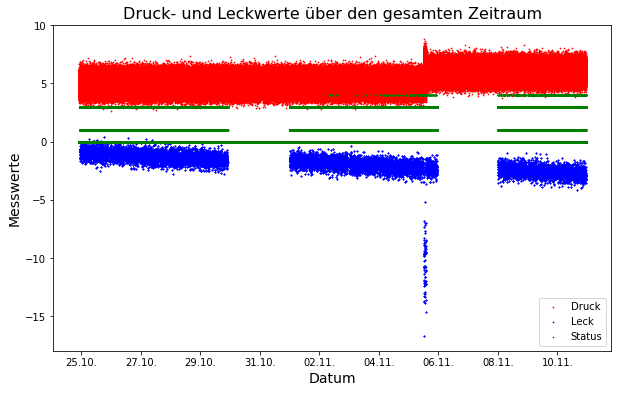

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df.date, df.druck, color='red', label='Druck', s=0.5)
ax.scatter(df.date, df.leck, color='blue', label='Leck', s=0.5)
ax.scatter(df.date, df.status, color='green', label='Status', s=0.5)

date_form = DateFormatter("%d.%m.")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # damit nicht direkt nach dem 31.10 der 01.11 angezeigt wird
ax.xaxis.set_major_formatter(date_form)

ax.set_title("Druck- und Leckwerte über den gesamten Zeitraum", fontsize=16)
ax.set_xlabel("Datum", fontsize=14)
ax.set_ylabel("Messwerte", fontsize=14)

plt.legend(loc=4)

In [6]:
X = df[['druck', 'leck']]
y = df['status']

In [7]:
X

,druck,leck
0,5.362381,0.0
1,4.604942,0.0
2,6.139246,0.0
3,5.217539,0.0
4,4.224132,0.0
...,...,...
1455419,5.547973,0.0
1455420,6.251326,0.0
1455421,5.337404,0.0
1455422,6.055028,0.0


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
pipe.fit(X_train, y_train)  # apply scaling on training data

pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

0.5562530231740029

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tslearn.svm import TimeSeriesSVC

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.75)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print("Correct classification rate:", knn.score(X_test, y_test))

Correct classification rate: 0.52243744778154


Text(0.5, 1.0, 'Confusion matrix')

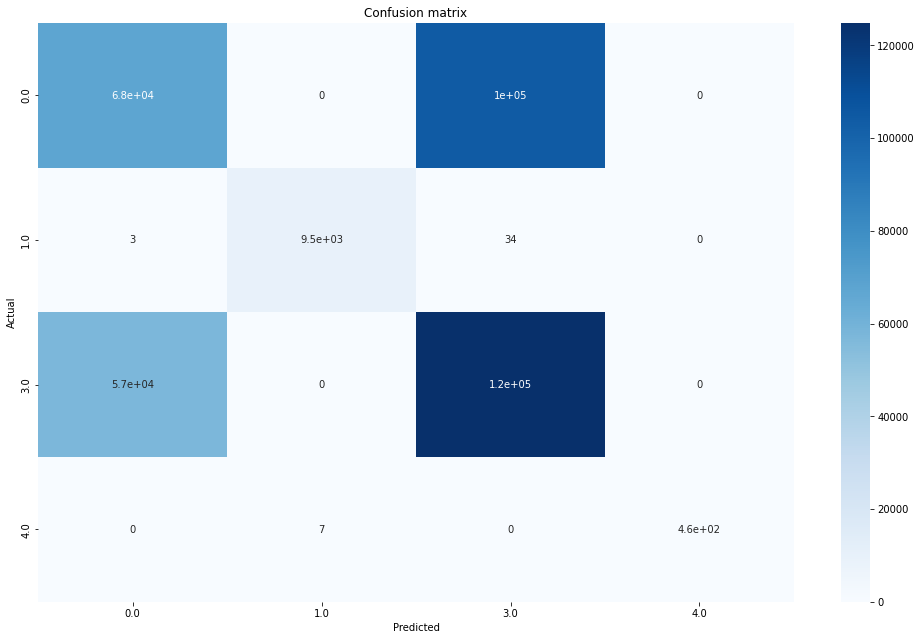

In [20]:
from sklearn.metrics import confusion_matrix

conf_df = df['status'].drop_duplicates().sort_values()
pipe_pred = pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, pipe_pred)
plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.180, bottom=0.280, right=1.0, top=0.950)
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=conf_df,
            yticklabels=conf_df,
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.title('Confusion matrix')

man sieht, dass die Klassifizierung vor allem bei Status 0 (Maschine im Leerlauf) und 3 (Bauteil in Maschine) schlecht ist.
Da diese Unterscheidung nicht wirklich interessant ist, kann diese Unterscheidung vernachlässigt werden.
Es wird im Folgenden nur zwischen Status 1 (Bauteil in Ordnung), 2 (Teil muss wegeschmissen werden (kommt in diesem DF nicht vor)) und 4 (Teil muss nachbearbeitet werden) unterschieden

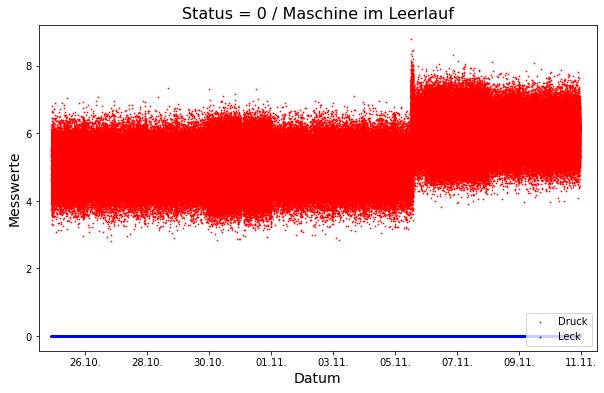

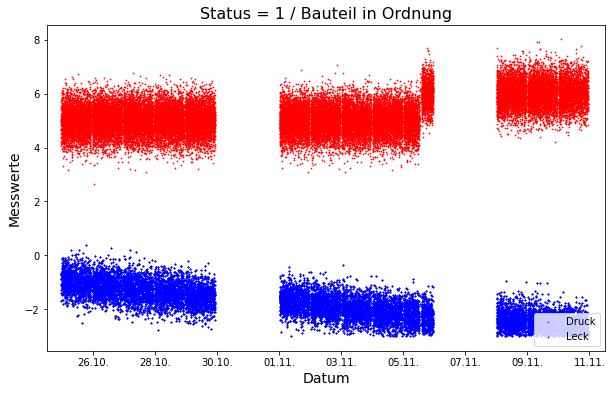

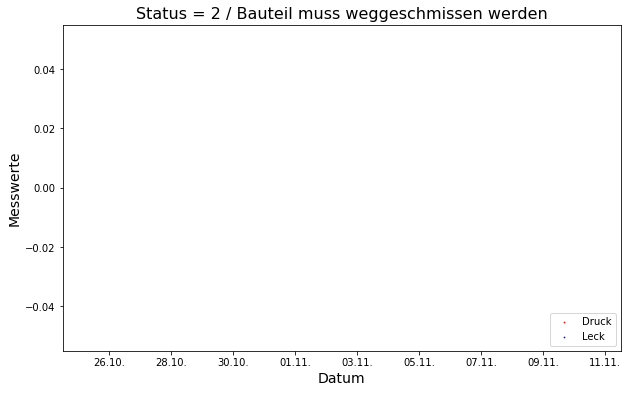

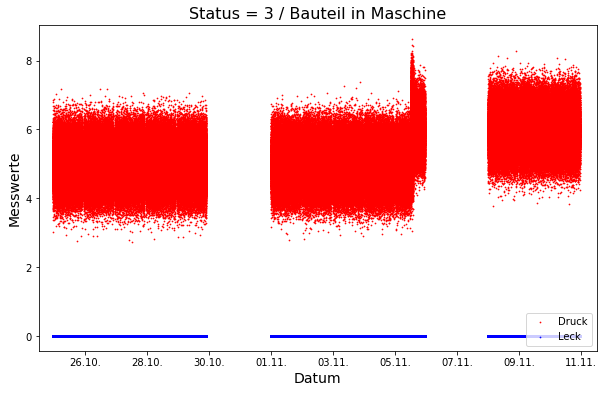

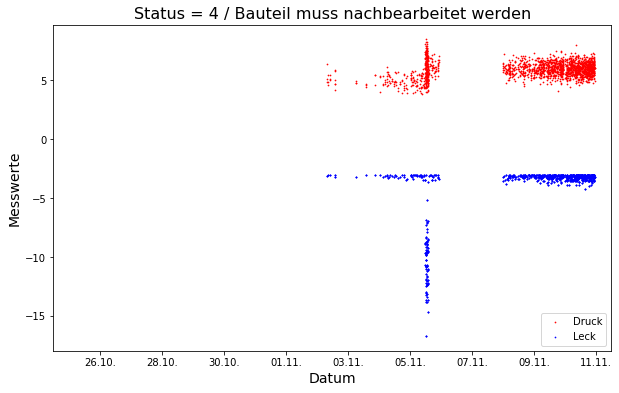

In [38]:
# was bedeuten Status 0 bis 4?
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

explanation = (" / Maschine im Leerlauf"," / Bauteil in Ordnung"," / Bauteil muss weggeschmissen werden"," / Bauteil in Maschine"," / Bauteil muss nachbearbeitet werden") 

for i in range(0,5):
    sample = df[df.status == i]
    fig, ax = plt.subplots(figsize=(10,6))
    ax.scatter(sample.date, sample.druck, color='red', label='Druck', s=0.5)
    ax.scatter(sample.date, sample.leck, color='blue', label='Leck', s=0.5)

    ax.set_xlim([datetime.datetime(2021, 10, 24, 12, 0, 0), datetime.datetime(2021, 11, 11, 12, 0, 0)])
    ax.set_title("Status = " + str(i) + explanation[i], fontsize=16)

    ax.set_xlabel("Datum", fontsize=14)
    ax.set_ylabel("Messwerte", fontsize=14)

    date_form = DateFormatter("%d.%m.")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # damit nicht direkt nach dem 31.10 der 01.11 angezeigt wird
    plt.legend(loc=4)

In [12]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=1, max_iter=1000)
mlp.fit(X_train, y_train)
print("Correct classification rate:", mlp.score(X_test, y_test))

Correct classification rate: 0.5474720768655732


In [11]:
clf = TimeSeriesSVC(kernel="gak", gamma=.1)
clf.fit(X_train, y_train)
print("Correct classification rate:", clf.score(X_test, y_test))

MemoryError: Unable to allocate 8.67 TiB for an array with shape (1091568, 1091568) and data type float64

In [9]:
n_classes = len(set(y_train))
plt.figure()
support_vectors = clf.support_vectors_
for i, cl in enumerate(set(y_train)):
    plt.subplot(n_classes, 1, i + 1)
    plt.title("Support vectors for class %d" % cl)
    for ts in support_vectors[i]:
        plt.plot(ts.ravel())

plt.tight_layout()
plt.show()

NameError: name 'clf' is not defined

<Figure size 432x288 with 0 Axes>

In [28]:
df_reduced = df[(df.status != 3) & (df.status != 0)]

In [34]:
X_new = df_reduced[['druck', 'leck']]
y_new = df_reduced['status']

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test) 

0.9986044657097288

Text(0.5, 1.0, 'Confusion matrix')

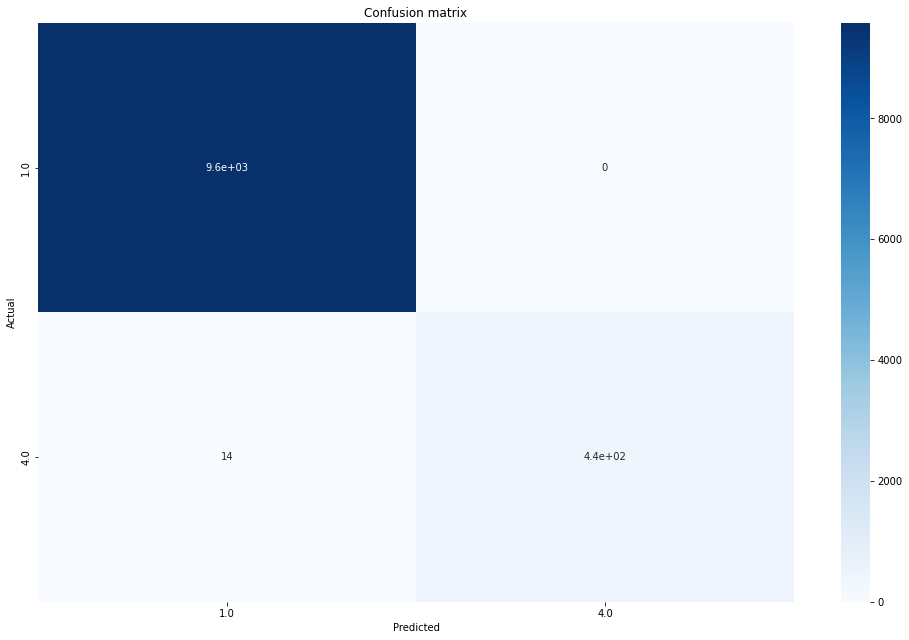

In [37]:
from sklearn.metrics import confusion_matrix

conf_df = df_reduced['status'].drop_duplicates().sort_values()
pipe_pred = pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, pipe_pred)
plt.figure(figsize=(16, 12))
plt.subplots_adjust(left=0.180, bottom=0.280, right=1.0, top=0.950)
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=conf_df,
            yticklabels=conf_df,
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
plt.title('Confusion matrix')